# Reproduce extraction & graph creation


## Extract incidents from Non-anonymized data
- 
- Extract incidents and alerts from the alphine ski house data and save them to csv.

In [8]:
import pandas as pd
import os
import json


# load data
base_path = "../env/data_723/alphineskihouse/"
incident_path = os.path.join(base_path, "SecurityIncident.csv")
sep = "❖"
security_incident = pd.read_csv(incident_path, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
alert_path_1 = os.path.join(base_path, "SecurityAlert/SecurityAlert_0.csv")
alert_path_2 = os.path.join(base_path, "SecurityAlert/SecurityAlert_1.csv")
security_alert =  pd.read_csv(alert_path_1, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
security_alert_2 = pd.read_csv(alert_path_2, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
security_alert = pd.concat([security_alert, security_alert_2])


# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# ----------------------------filter_incidents--------------------------
# sort by time
security_incident["TimeGenerated"] = pd.to_datetime(security_incident["TimeGenerated"], format='mixed')
security_incident = security_incident.sort_values(by="TimeGenerated")

security_alert["TimeGenerated"] = pd.to_datetime(security_alert["TimeGenerated"], format='mixed')
security_alert = security_alert.sort_values(by="TimeGenerated")


# 1. Filter by LATEST label
filtered_incidents = []
for i, incident in security_incident.iterrows():
    labels = json.loads(incident['Labels'])
    # check if the incident is the latest in one line
    is_latest = any([label['labelName'] == 'LATEST' for label in labels])
    if is_latest:
        filtered_incidents.append(incident)

filtered_incidents = pd.DataFrame(filtered_incidents)

# unique incident numbers
incident_numbers = filtered_incidents['IncidentNumber'].unique()


# 2. for each incdent number, get the latest incident generated and put in a new dataframe
latest_incidents = []
for incident_number in incident_numbers:
    incident = filtered_incidents[filtered_incidents['IncidentNumber'] == incident_number]
    latest_incidents.append(incident.iloc[-1])
    
latest_incidents = pd.DataFrame(latest_incidents)

# 3. filter by time and remove repeated incidents
start_time = pd.to_datetime("2024-06-18T00:00:00Z")
end_time = pd.to_datetime("2024-08-02T00:00:00Z")

latest_incidents["FirstActivityTime"] = pd.to_datetime(latest_incidents["FirstActivityTime"], format='mixed')
latest_incidents = latest_incidents[latest_incidents["FirstActivityTime"] > start_time]
latest_incidents = latest_incidents[latest_incidents["FirstActivityTime"] < end_time]


# remove 290, 175, 122
latest_incidents = latest_incidents[latest_incidents['IncidentNumber'] != 290]
latest_incidents = latest_incidents[latest_incidents['IncidentNumber'] != 175]
latest_incidents = latest_incidents[latest_incidents['IncidentNumber'] != 122]

print(len(latest_incidents))

print("Num of incidents extracted: ", len(latest_incidents))


# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# -----------------------save extracted incidents-----------------------
def extract_alert(alert_ids, security_alert):
    found_alert_ids = []
    alerts_to_return = []
    for alert in security_alert.iterrows():
        if alert[1]['SystemAlertId'] in alert_ids and alert[1]['SystemAlertId'] not in found_alert_ids:
            alerts_to_return.append(alert[1])
            found_alert_ids.append(alert[1]['SystemAlertId'])
    return alerts_to_return

output_path = "./extracted_incidents_non_anony.csv"
latest_incidents.to_csv(output_path, index=False, encoding='utf-8', sep=sep)

all_alerts = []
for _, incident in latest_incidents.iterrows():
    alert_ids = json.loads(incident['AlertIds'])
    alerts = extract_alert(alert_ids, security_alert)
    all_alerts.extend(alerts)

all_alerts = pd.DataFrame(all_alerts)
output_path = "./extracted_alerts_non_anony.csv"
all_alerts.to_csv(output_path, index=False, encoding='utf-8', sep=sep)



7
Num of incidents extracted:  7


## Construct graphs from incidents
- Load the saved incidents and alerts
- Construct a graph from the incidents and alerts, only save the largest connected component from one incident.
- Save to graphml format.

In [9]:
import pandas as pd
import os
import json
from secgym.qagen.alert_graph import AlertGraph

def extract_alert(alert_ids, security_alert):
    found_alert_ids = []
    alerts_to_return = []
    for alert in security_alert.iterrows():
        if alert[1]['SystemAlertId'] in alert_ids and alert[1]['SystemAlertId'] not in found_alert_ids:
            alerts_to_return.append(alert[1])
            found_alert_ids.append(alert[1]['SystemAlertId'])
    return alerts_to_return

def get_incident_alert_pairs(path="./"):
    with open(os.path.join(path, "extracted_incidents_non_anony.csv")) as f:
        incidents = pd.read_csv(f, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
    
    with open(os.path.join(path, "extracted_alerts_non_anony.csv")) as f:
        all_alerts = pd.read_csv(f, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')

    incident_alert_pairs = []
    for _, incident in incidents.iterrows(): 
        alert_ids = json.loads(incident['AlertIds'])
        alerts = extract_alert(alert_ids, all_alerts)
        incident_alert_pairs.append((incident, alerts))

    return incident_alert_pairs


incident_alert_pairs = get_incident_alert_pairs()


for i in range(len(incident_alert_pairs)):
    a, b = incident_alert_pairs[i]
    alert_graph = AlertGraph()

    inumber = incident_alert_pairs[i][0]["IncidentNumber"]
    alert_graph.build_graph_from_incident_alert(a,b)
    alert_graph.save_to_graphml(filepath=f"./graph_files_non_anony/incident_{inumber}.graphml")


Number of distinct subgraphs: 2
> Prune the graph to keep only the largest connected component.
Graph saved to ./graph_files_non_anony/incident_5.graphml
Graph saved to ./graph_files_non_anony/incident_38.graphml
Graph saved to ./graph_files_non_anony/incident_34.graphml
Number of distinct subgraphs: 2
> Prune the graph to keep only the largest connected component.
Graph saved to ./graph_files_non_anony/incident_39.graphml
Graph saved to ./graph_files_non_anony/incident_55.graphml
Graph saved to ./graph_files_non_anony/incident_134.graphml
Graph saved to ./graph_files_non_anony/incident_166.graphml


incident_322.graphml 38


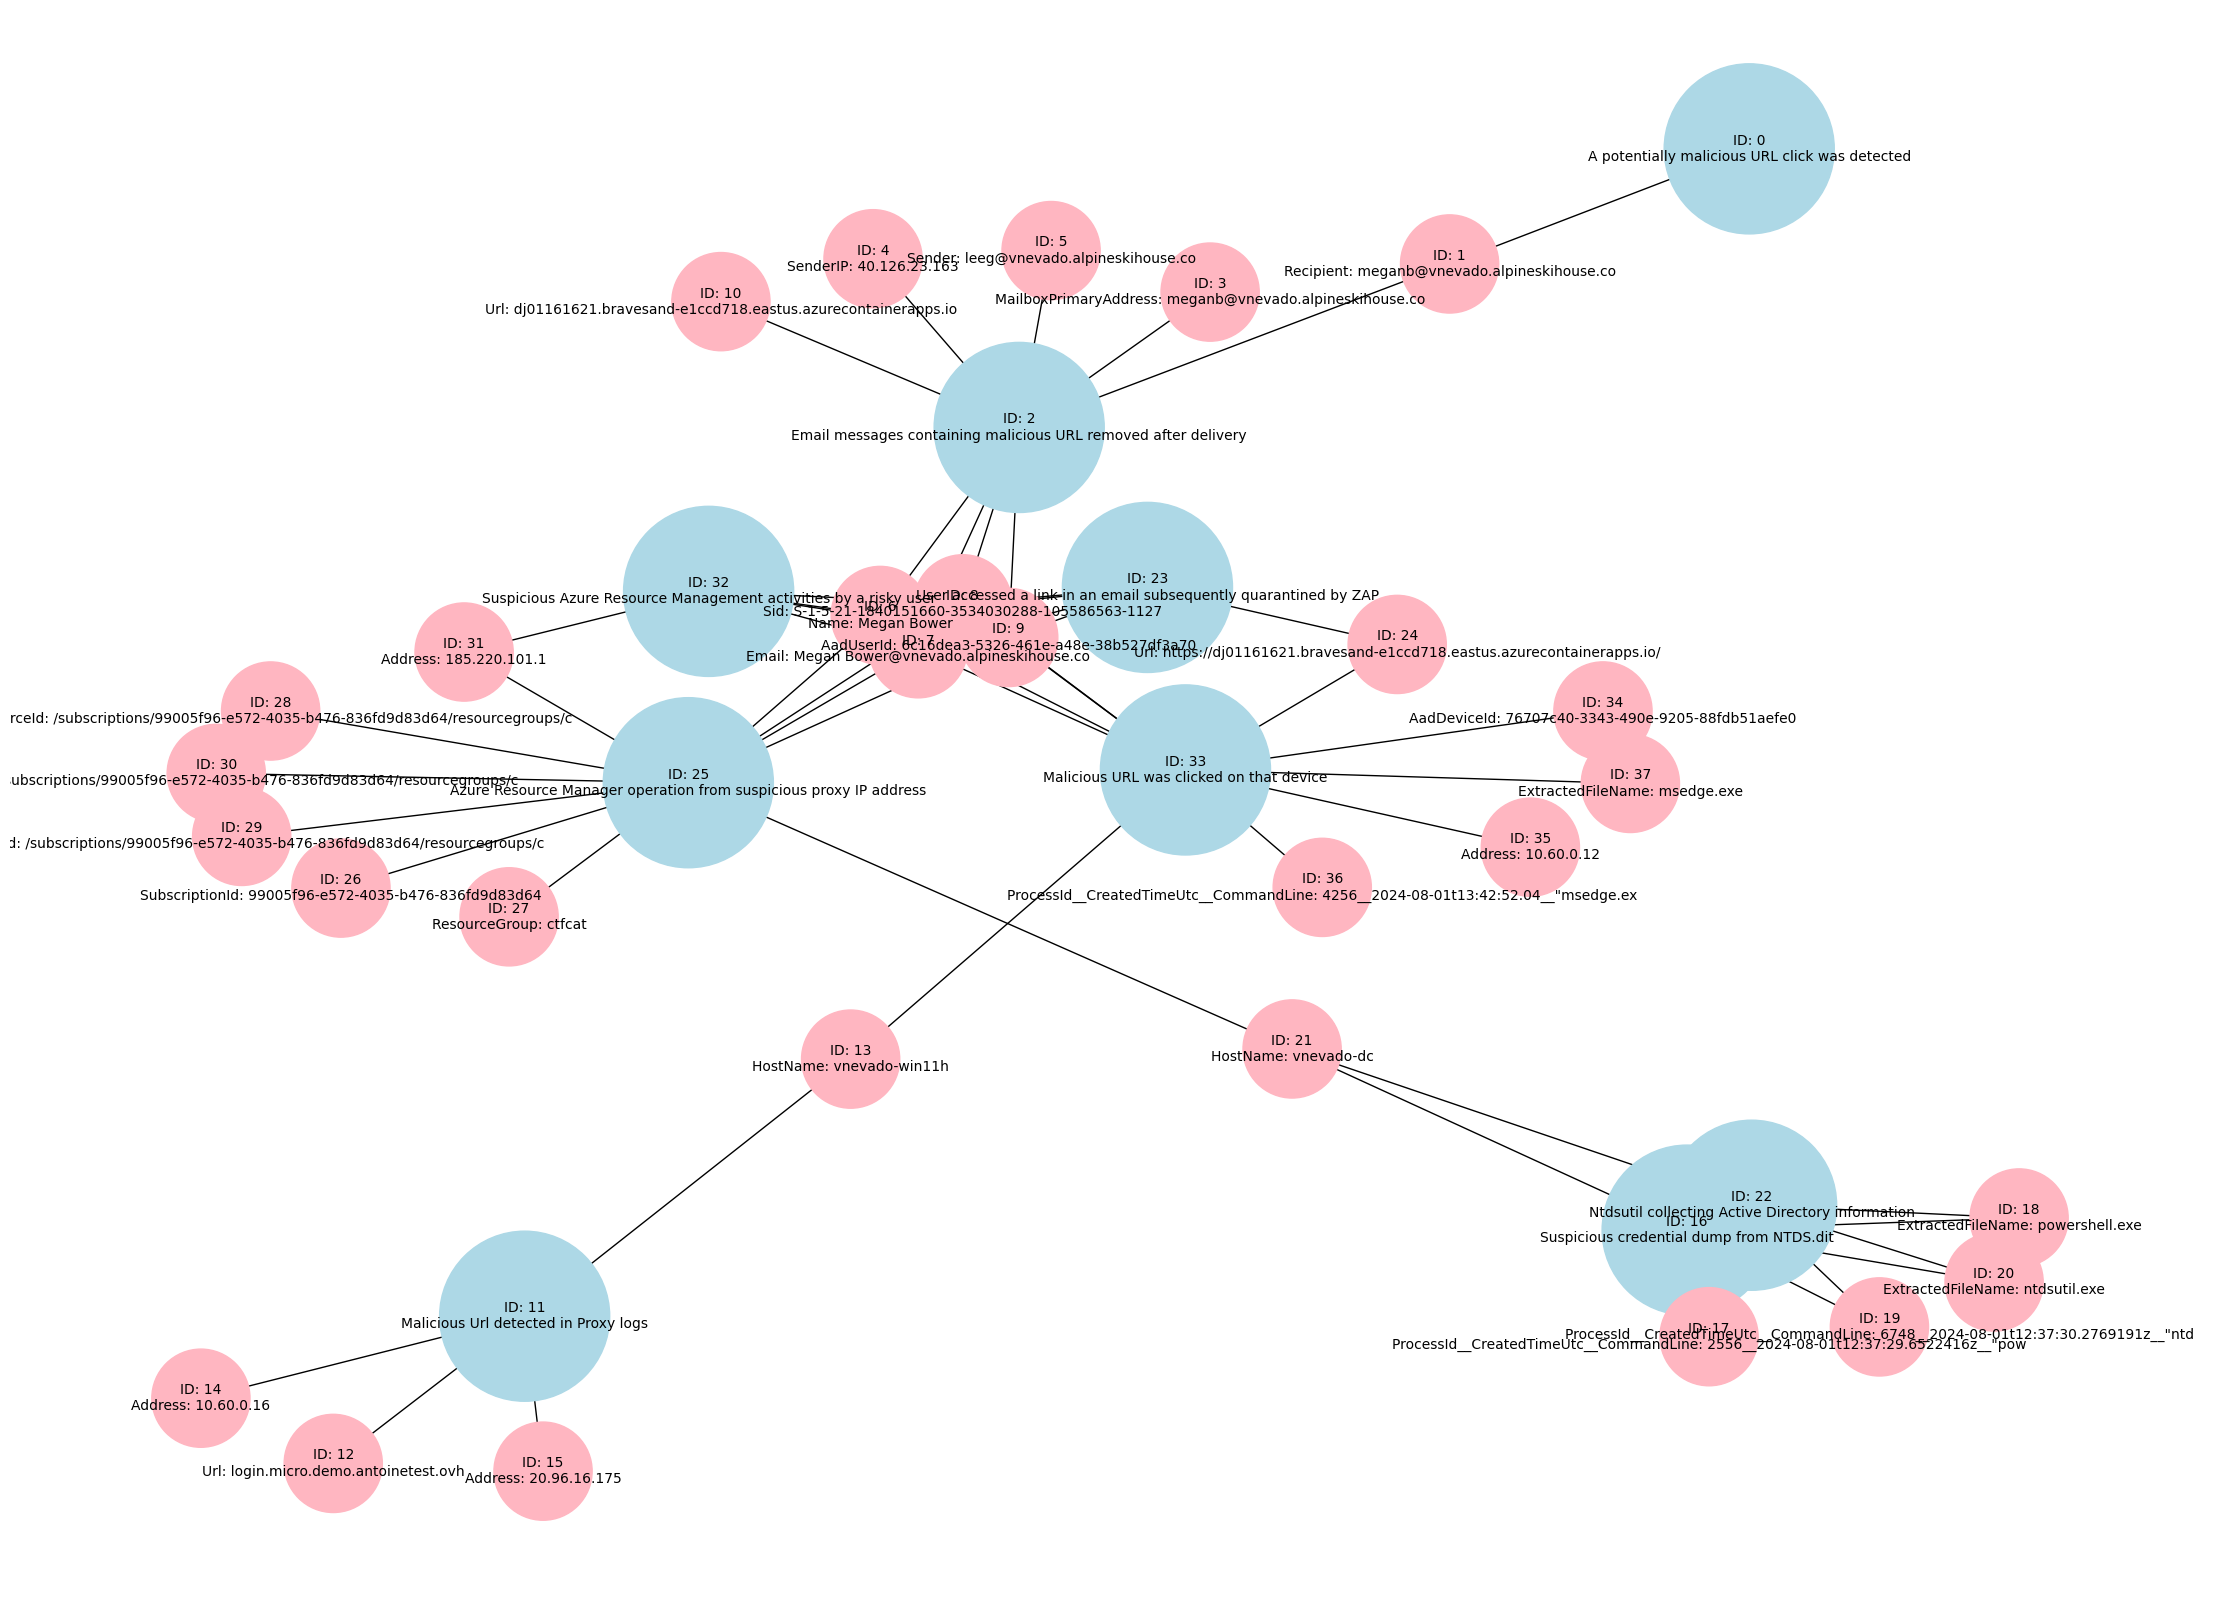

In [15]:
from secgym.qagen.alert_graph import AlertGraph
import os

# iterate over folder

for filename in os.listdir("./graph_files_non_anony"):
    if filename.endswith(".graphml"):
        alert_graph = AlertGraph()
        alert_graph.load_graph_from_graphml(filepath=f"./graph_files_non_anony/{filename}")
        print(filename, len(alert_graph.graph.nodes))
        alert_graph.plot_custom_graph(layout="fruchterman_reingold")


Validation: 
question: id 11 -> id 0   11-33-2-0 

Train:
question: id 2 -> 0

In [16]:
alert_graph.incident

TenantId                               e34d562e-ef12-4c4e-9bc0-7c6ae357c015
TimeGenerated                              2024-08-14 22:40:25.151349+00:00
IncidentName                           909f13db-13ce-4584-a4b5-6aa0e67397c6
Title                     Multi-stage incident involving Initial access ...
Description                                                             NaN
Severity                                                               High
Status                                                                  New
Classification                                                          NaN
ClassificationComment                                                   NaN
ClassificationReason                                                    NaN
Owner                     {"objectId":null,"email":null,"assignedTo":"Mi...
ProviderName                                                  Microsoft XDR
ProviderIncidentId                                                      801
FirstActivit

In [24]:
# save alert graph.incident to csv

incident = pd.DataFrame([alert_graph.incident])
incident.to_csv("incident_322.csv", index=False)


# save alert graph.alerts to csv. Note alerts is a list of pandas series

alerts = alert_graph.alerts
alerts = pd.DataFrame(alerts)
alerts.to_csv("alerts_322.csv", index=False)

In [7]:
from secgym.qagen.alert_graph import AlertGraph
import os

# iterate over folder
files = os.listdir("./graph_files_non_anony")
files

['incident_34.graphml',
 'incident_166.graphml',
 'incident_55.graphml',
 'incident_5.graphml',
 'incident_38.graphml',
 'incident_134.graphml',
 'incident_39.graphml',
 'incident_322.graphml']

In [1]:
import networkx as nx
from secgym.qagen.alert_graph import AlertGraph
import os

# get max distance between any two nodes

problem_count = {
    1: 0,
}

dpath = "/Users/kevin/Downloads/SecRL/secgym/qagen/graph_files"

for filename in os.listdir(dpath):
    if filename.endswith(".graphml"):
        print(filename)
        alert_graph = AlertGraph()
        alert_graph.load_graph_from_graphml(filepath=f"{dpath}/{filename}")
        # alert_graph.plot_custom_graph()

        all_paths = alert_graph.get_alert_paths(k=1, verbose=False)
        for a in all_paths:
            hop = len(a['shortest_alert_path'])//2 + 1
            if hop in problem_count:
                problem_count[hop] += 1
            else:
                problem_count[hop] = 1

        print("-------------------")
        # max_distance = 0
        # for node in alert_graph.graph.nodes:
        #     for other_node in alert_graph.graph.nodes:
        #         if node != other_node:
        #             try:
        #                 distance = nx.shortest_path_length(alert_graph.graph, node, other_node)
        #                 if distance > max_distance:
        #                     max_distance = distance
        #             except:
        #                 pass
        # print(filename, len(alert_graph.graph.nodes), max_distance)

# print(max_distance)

incident_34.graphml
Total alert paths: 111. Expected: alert_num ^ 2 = 121, Selected: 111
-------------------
incident_166.graphml
Total alert paths: 113. Expected: alert_num ^ 2 = 121, Selected: 113
-------------------
incident_55.graphml
Total alert paths: 723. Expected: alert_num ^ 2 = 729, Selected: 723
-------------------
incident_5.graphml
Total alert paths: 4583. Expected: alert_num ^ 2 = 4624, Selected: 4583
-------------------
incident_38.graphml
Total alert paths: 16. Expected: alert_num ^ 2 = 16, Selected: 16
-------------------
incident_134.graphml
Total alert paths: 76. Expected: alert_num ^ 2 = 81, Selected: 76
-------------------
incident_39.graphml
Total alert paths: 2165. Expected: alert_num ^ 2 = 2209, Selected: 2165
-------------------
incident_322.graphml
Total alert paths: 78. Expected: alert_num ^ 2 = 81, Selected: 78
-------------------


In [15]:
import networkx as nx
from secgym.qagen.alert_graph import AlertGraph
import os

# get max distance between any two nodes

problem_count = {
    1: 0,
}

for filename in os.listdir("./graph_files"):
    if filename.endswith(".graphml"):
        print(filename)
        alert_graph = AlertGraph()
        alert_graph.load_graph_from_graphml(filepath=f"./graph_files/{filename}")
        # alert_graph.plot_custom_graph()

        all_paths = alert_graph.get_alert_paths(k=1, verbose=False)
        for a in all_paths:
            hop = len(a['shortest_alert_path'])//2 + 1
            if hop in problem_count:
                problem_count[hop] += 1
            else:
                problem_count[hop] = 1

        print("-------------------")
        # max_distance = 0
        # for node in alert_graph.graph.nodes:
        #     for other_node in alert_graph.graph.nodes:
        #         if node != other_node:
        #             try:
        #                 distance = nx.shortest_path_length(alert_graph.graph, node, other_node)
        #                 if distance > max_distance:
        #                     max_distance = distance
        #             except:
        #                 pass
        # print(filename, len(alert_graph.graph.nodes), max_distance)

# print(max_distance)

incident_34.graphml
Total alert paths: 121. Expected: alert_num ^ 2 = 121
-------------------
incident_166.graphml
Total alert paths: 121. Expected: alert_num ^ 2 = 121
-------------------
incident_55.graphml
Alert 80 has only one entity connected, skip.
Total alert paths: 288. Expected: alert_num ^ 2 = 289
-------------------
incident_5.graphml
Total alert paths: 4624. Expected: alert_num ^ 2 = 4624
-------------------
incident_38.graphml
Total alert paths: 16. Expected: alert_num ^ 2 = 16
-------------------
incident_134.graphml
Total alert paths: 81. Expected: alert_num ^ 2 = 81
-------------------
incident_39.graphml
Alert 49 has only one entity connected, skip.
Total alert paths: 2208. Expected: alert_num ^ 2 = 2209
-------------------
incident_322.graphml
Alert 0 has only one entity connected, skip.
Alert 16 has only one entity connected, skip.
Alert 18 has only one entity connected, skip.
Total alert paths: 78. Expected: alert_num ^ 2 = 81
-------------------


In [16]:
problem_count

{1: 171, 2: 3872, 3: 1828, 4: 1628, 5: 38}

In [17]:
a = 0
for _, v in problem_count.items():
    a += v
a

7537